# Dataset Preprocessing

In [1]:
import numpy as np
import pandas as pd
from rdkit import (Chem, RDLogger)
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

## Molecule, Descriptor, and Outlier Utility Functions

### `molecule_from_smiles(smiles)`
Converts a SMILES string into a cleaned **RDKit molecule object**, while temporarily silencing RDKit logs to avoid console spam.

**Process:**
1. Parse the SMILES into an RDKit molecule (`Chem.MolFromSmiles`).
2. Remove salts and keep the **largest fragment** using `LargestFragmentChooser`.
3. Re-sanitize the molecule to ensure validity.
4. Logging is muted during processing and restored afterward.

**Returns:**
- `(molecule, status)`  
  - `molecule`: RDKit molecule object or `None`  
  - `status`: `"succeed"`, `"failed"`, or `"error: <message>"`

---

### `calculate_descriptors(molecule)`
Calculates all available **1D and 2D molecular descriptors** using RDKit’s built-in descriptor list.

**Steps:**
1. Collect all descriptor names from `Descriptors._descList`.  
2. Use `MolecularDescriptorCalculator` to compute their values for the molecule.  
3. Return as a dictionary mapping *descriptor name → value*.

**Returns:**
- `dict`: `{ descriptor_name: value }`

---

### `outliers_iqr(df, factor=1.5)`
Applies the **Interquartile Range (IQR)** rule to cap extreme numeric values.

**Process:**
- Compute Q1 (25%) and Q3 (75%) for each column.  
- Define bounds: `[Q1 − 1.5×IQR, Q3 + 1.5×IQR]`.  
- Values beyond these limits are **clipped** to the nearest boundary.  
- Columns with zero IQR (flat values) are skipped.

**Purpose:**
Removes the influence of outliers **without deleting rows**, preserving dataset structure and stabilizing machine learning models.

In [2]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def outliers_iqr(df, factor=1.5):
    df_copy = df.copy()
    for col in df_copy.columns:
        # Only for numeric columns, but clean_desc should already be numeric
        q1 = df_copy[col].quantile(0.25)
        q3 = df_copy[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat → skip
        if iqr == 0:
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr

        # Apply the IQR limits
        df_copy[col] = df_copy[col].clip(lower, upper)
    return df_copy

## Dataset Processing and Descriptor Cleaning Pipeline

This notebook processes the *in chemico* dataset by:
- Converting SMILES strings into RDKit molecule objects  
- Computing 1D/2D molecular descriptors  
- Cleaning and preparing descriptors for machine learning  

It produces two key outputs:
1. **Full Excel report** – original dataset + raw descriptors + molecule build status  
2. **Clean CSV files** – train/test feature matrices ready for ML modeling

---

### Configuration Variables

| Variable | Description |
|-----------|--------------|
| `ORIG_DATASET` | Path to the original Excel file with SMILES and labels |
| `SKIP_ROWS` | Number of rows to skip at the top of the Excel file (e.g. non-data header) |
| `SMILES_COL` | Column name containing SMILES strings |
| `TARGET_COL` | Column name of the target variable (e.g. `Phototoxicity`) |
| `FULL_OUTPUT_DATASET` | Excel output with all raw descriptors + molecule status |
| `TRAIN_X_CSV`, `TEST_X_CSV` | Clean numeric descriptor files for ML (train/test) |
| `TRAIN_Y_CSV`, `TEST_Y_CSV` | Corresponding label files for ML (train/test) |
| `SIMILARITY_THRESHOLD` | Drop descriptors where ≥ this fraction of values are identical (e.g. 0.80 = 80%) |

---

### Workflow Overview

#### 1 Load the Dataset
- Read the Excel file specified by `ORIG_DATASET` using `pandas.read_excel()`.
- Skip any non-data rows (`SKIP_ROWS`).

#### 2 Convert SMILES → RDKit Molecules
- Loop through the SMILES column (`SMILES_COL`).
- Convert each SMILES to an RDKit `Mol` object using `molecule_from_smiles()`.
- Track molecule build status (`"succeed"`, `"failed"`, or `"error: ..."`).

#### 3 Compute RDKit Descriptors
- For each valid molecule, compute 1D/2D descriptors with `calculate_descriptors()`.
- Store descriptor values as dictionaries in a list.

#### 4 Build the Descriptor Table
- Convert the list of descriptor dictionaries into a single `pandas.DataFrame`.
- Each **descriptor** becomes a **column**; each **molecule** becomes a **row**.

#### 5 Descriptor Cleaning (Leak-Free)
All cleaning is fitted **only on the training set** to prevent data leakage:
- Keep only **numeric** descriptor columns.
- Replace `inf` and `-inf` values with `NaN`.
- Fill missing values with the **median** from the **training set**.
- Drop **constant or near-constant** descriptors where ≥ `SIMILARITY_THRESHOLD` of values are identical.
- Apply **IQR-based clipping** (`outliers_iqr(df, factor=1.5)`) on the **training data only** to cap extreme outliers.

#### 6 Merge and Save Outputs
- Merge the **original dataset** and **raw descriptor data** into one DataFrame,  
  adding a `MoleculeStatus` column.
- Save:
  - The full annotated dataset → `FULL_OUTPUT_DATASET` (Excel)
  - Cleaned train/test features → `TRAIN_X_CSV` and `TEST_X_CSV`
  - Train/test labels → `TRAIN_Y_CSV` and `TEST_Y_CSV`

#### 7 Logging and Summary
After processing:
- Print the number of rows/columns for the full and clean datasets.
- List descriptors dropped as constant or almost constant.
- Show a preview (`head()`) of both full and cleaned feature sets.

---

### Notes
- Columns that are **completely NaN** are dropped *before splitting* (safe operation).
- Missing values, constant-column filtering, and IQR clipping are all **fit only on the training set**.
- This ensures a fully **data leakage–free** preprocessing pipeline, ready for ML experiments.

In [3]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant treshold - tolerance
SIMILARITY_THRESHOLD = 0.80

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

# Build descriptors
descriptor_rows = []
state_molecules = []
molecules = []

# Loop over the SMILES column
for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    # If molecule construction failed - empty placeholder
    if molecule is None:
        descriptor_rows.append({})
        continue
    # Calculate descriptors for each molecule
    descriptor_rows.append(calculate_descriptors(molecule))

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

X_train = outliers_iqr(X_train, factor=1.5)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

X_train.describe()

Full - Rows: 162/Columns: 230
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labute

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_C_O_noCOO,fr_NH0,fr_NH1,fr_aniline,fr_benzene,fr_bicyclic,fr_ether,fr_halogen,fr_para_hydroxylation,fr_pyridine
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,11.352259,11.352259,0.193352,-0.913807,0.606684,14.198433,317.702837,300.605333,317.265179,115.248062,...,0.593023,1.263566,0.434109,0.500000,1.317829,0.604651,0.523256,0.670543,0.294574,0.232558
std,2.430989,2.430989,0.188957,1.107129,0.211797,4.792314,126.620808,122.168050,126.421616,43.814066,...,0.772495,1.444382,0.632393,0.728869,0.819532,0.797149,0.800050,0.913219,0.564622,0.476177
min,6.194108,6.194108,0.000297,-3.038324,0.139518,6.000000,46.069000,40.021000,46.041865,20.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.206402,10.206402,0.052299,-1.315329,0.481898,10.857143,232.239000,220.143000,232.084792,88.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11.846296,11.846296,0.124071,-0.830880,0.652473,12.333333,313.788000,297.660000,313.098190,112.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.881264,12.881264,0.277145,-0.166667,0.791627,16.678571,381.379000,367.267000,381.075882,138.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,15.645307,15.645307,0.614414,1.311296,0.893230,25.410714,605.089000,587.953000,604.562518,213.000000,...,2.500000,5.000000,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,2.000000,2.000000


## Model Training and Evaluation

This section loads the **preprocessed, leak-free** training and testing datasets generated earlier
and trains an **XGBoost binary classifier** to predict phototoxicity outcomes.

### Workflow Summary
1. **Load data**
   - `X_train`, `X_test`: feature matrices (numeric descriptors)
   - `y_train`, `y_test`: corresponding target labels
   - Performs alignment checks to ensure features and labels match.

2. **Initialize XGBoost model**
   Uses default core hyperparameters (tunable later via Optuna or grid search).
   - `tree_method="auto"` automatically selects the best GPU/CPU backend.
   - `eval_metric=["logloss", "auc"]` tracks classification performance.

3. **Train model**
   Fits on `X_train`, evaluates on `(X_test, y_test)` without printing per-epoch logs.

4. **Predict and evaluate**
   - Computes Accuracy, Precision, Recall, F1, and ROC AUC.
   - Prints a full classification report.
   - Plots a **confusion matrix** and **ROC curve** for visual performance assessment.

5. **Feature importance analysis**
   - Extracts and ranks features by gain-based importance (`model.feature_importances_`).
   - Saves the full ordered feature list to `top_features_best.csv`.

---

**Outputs**
- Model performance metrics printed in console
- Confusion matrix and ROC curve plots
- `top_features_best.csv` with feature importance ranking

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Config
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"
FEATURE_IMPORT_CSV = "top_features_best.csv"

# Read X and y
X_train = pd.read_csv(TRAIN_X_CSV)
X_test = pd.read_csv(TEST_X_CSV)
y_train = pd.read_csv(TRAIN_Y_CSV).squeeze()
y_test = pd.read_csv(TEST_Y_CSV).squeeze()
#.squeeze() автоматически превращает DataFrame (162×1) → Series (162,). Ты читаешь CSV с помощью pandas.read_csv, и он создаёт DataFrame (2D объект), а не Series (1D). Просто “разверни” вектор в 1D


# Checks Проверка целостности. Проверяет, что: train/test имеют одинаковые колонки (иначе модель не сможет обучиться);
assert list(X_train.columns) == list(X_test.columns), "Train/Test feature columns are misaligned."
assert len(X_train) == len(y_train) and len(X_test) == len(y_test), "X/y rows are misaligned."

model = RandomForestClassifier(
    n_estimators=134,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)


# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test) #предсказанные метки (0 или 1)
y_prob = model.predict_proba(X_test)[:, 1] #вероятность “быть токсичным” (для ROC AUC и графиков)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance:
Accuracy : 0.6364
Precision: 0.6875
Recall   : 0.6111
F1 score : 0.6471
ROC AUC  : 0.7463

Classification report:
              precision    recall  f1-score   support

           0      0.588     0.667     0.625        15
           1      0.688     0.611     0.647        18

    accuracy                          0.636        33
   macro avg      0.638     0.639     0.636        33
weighted avg      0.642     0.636     0.637        33



The Random Forest model was trained to predict molecular phototoxicity based on computed chemical descriptors. The results showed moderate accuracy (Accuracy = 0.64) and satisfactory discriminative ability (ROC AUC = 0.75), indicating that the model can identify toxic compounds with acceptable reliability. The higher precision compared to recall suggests that the model makes fewer mistakes when predicting toxicity but occasionally misses some truly toxic samples. Overall, the model performs consistently, though it could be improved through finer parameter tuning and feature selection.



Top 20 features:
          feature  importance
        PEOE_VSA8    0.047586
MaxAbsEStateIndex    0.022898
       ExactMolWt    0.019135
            Chi2v    0.018477
            MolWt    0.016769
      EState_VSA5    0.016625
     BCUT2D_MWLOW    0.016433
   HeavyAtomMolWt    0.016130
   MaxEStateIndex    0.016081
            Chi0n    0.016065
            Chi3v    0.016052
          BertzCT    0.015935
         SMR_VSA7    0.014470
        SMR_VSA10    0.014401
            Chi4v    0.014320
             Chi0    0.014249
            Chi4n    0.014056
          fr_Ar_N    0.013638
         SMR_VSA3    0.013602
      EState_VSA3    0.013586


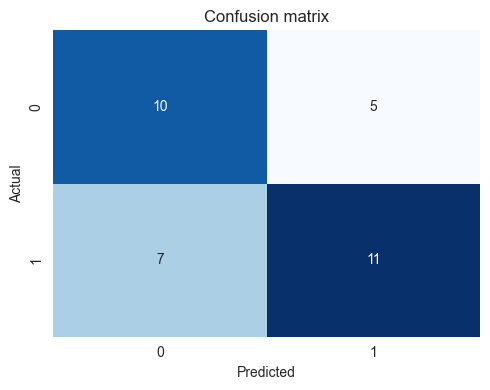

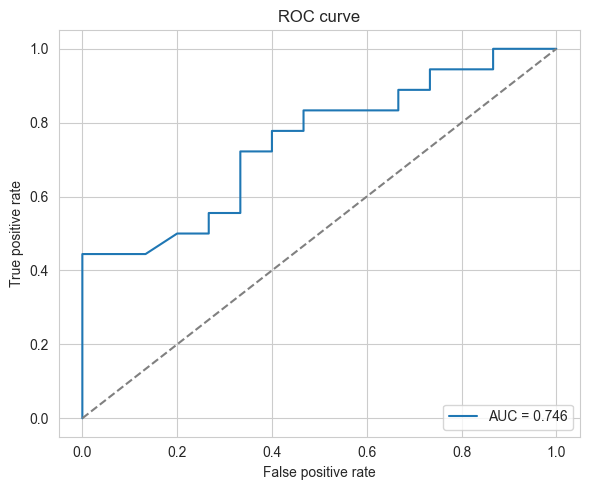

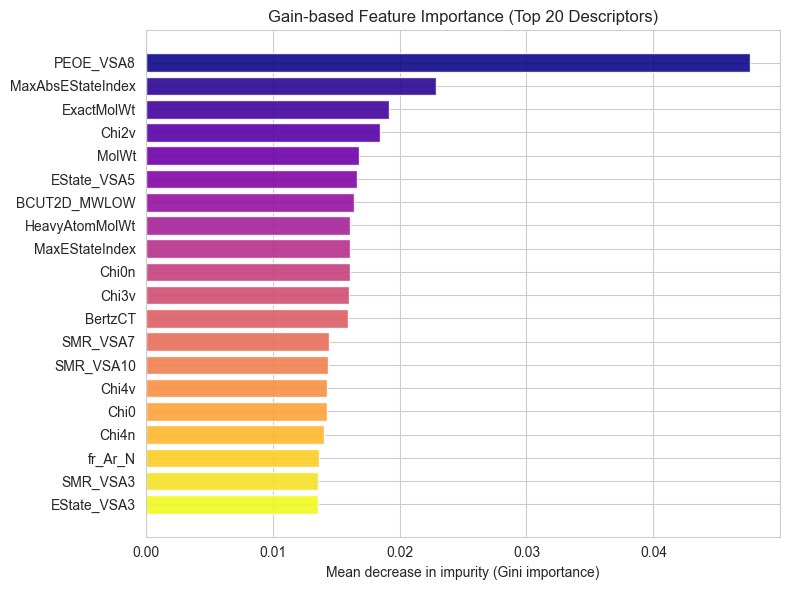

In [5]:
# Gain-based by default model.feature_importances_
# даёт понимание, какие признаки влияют, но не показывает, сколько из них действительно нужно.
feat_imp = pd.DataFrame({
    "feature": X_train.columns,  # список всех признаков (дескрипторов)
    "importance": model.feature_importances_  # вектор чисел (одинаковой длины), который Random Forest возвращает после обучения. Каждое число показывает, насколько этот признак важен для финального решения модели.
}).sort_values("importance", ascending=False)


# Most important first
feat_imp = feat_imp.sort_values("importance", ascending=False).reset_index(drop=True)

print("\nTop 20 features:")
print(feat_imp.head(20).to_string(index=False))

# Save ordered features
feat_imp.to_csv(FEATURE_IMPORT_CSV, index=False)

# Confusion Matrix  Показывает сколько примеров каждого класса модель предсказала правильно / неправильно.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")
plt.tight_layout()
plt.show()

# ROC Curve ROC-кривая показывает, как меняется соотношение ложных/истинных срабатываний при разных порогах.

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Топ-20 фіч за gain-based importance
top_gain = feat_imp.head(20)
y_pos = np.arange(len(top_gain))

plt.figure(figsize=(8, 6))
plt.barh(
    y=y_pos,
    width=top_gain["importance"],
    color=plt.cm.plasma(np.linspace(0, 1, len(top_gain))),  # можна змінити на 'viridis'
    alpha=0.9
)
plt.yticks(y_pos, top_gain["feature"])
plt.gca().invert_yaxis()  # Найважливіші зверху
plt.xlabel("Mean decrease in impurity (Gini importance)")
plt.title("Gain-based Feature Importance (Top 20 Descriptors)")
plt.tight_layout()
plt.show()


### 🔹 Hodnotenie kvality modelu a analýza príspevku jednotlivých deskriptorov

Táto sekcia predstavuje **hodnotenie kvality modelu** a **analýzu príspevkov jednotlivých deskriptorov**.
Model **Random Forest** bol zvolený preto, že **spoľahlivo funguje s veľkým počtom korelovaných chemických príznakov**
a **automaticky odhaduje, ktoré z nich sú skutočne dôležité**.

Kľúčové deskriptory boli identifikované pomocou **metódy Gini importance (gain-based feature importance)**,
ktorá je **zabudovaná priamo v algoritme Random Forest**.
**Táto metóda meria, do akej miery každý deskriptor znižuje neistotu počas budovania rozhodovacích stromov —
teda ako často a efektívne sa používa na presné rozdelenie dát.**
Bola zvolená preto, že **spoľahlivo funguje s veľkými množinami korelovaných čŕt**,
**nevyžaduje dodatočné výpočty** a **priamo odráža reálny vplyv každého deskriptora na rozhodnutia modelu**.

**Výsledky hodnotenia:**
- 🔸 **Confusion matrix** ukazuje, že model väčšinu predikcií vykonáva správne,
  aj keď niektoré **toxické zlúčeniny sú klasifikované ako netoxické** —
  čo možno vysvetliť **zložitou štruktúrou príznakov** a **obmedzenou veľkosťou datasetu**.
- 🔸 **ROC krivka (AUC = 0.75)** potvrdzuje, že model **spoľahlivo odlišuje toxické vzorky od bezpečných**.
- 🔸 **Najvplyvnejšie deskriptory** sú tie, ktoré súvisia s **elektrónovou hustotou a molekulovou hmotnosťou**
  (**PEOE_VSA8**, **ExactMolWt**) — práve tieto vlastnosti ovplyvňujú **interakciu molekúl so svetlom**,
  čo **logicky potvrdzuje správnosť a konzistenciu výsledkov**.


## Feature Selection Performance Sweep (Random Forest)

This section evaluates how model performance (Accuracy, F1, ROC AUC) changes as we include more **top-ranked molecular descriptors**, based on the Random Forest’s feature importances.

### Workflow Summary
1. Start with the **top 5 most important descriptors**.
2. Incrementally add more top descriptors (n = 5 → N_total).
3. For each subset:
   - Train a new **Random Forest classifier**
   - Evaluate performance on test set:
     - Accuracy
     - F1
     - ROC AUC
4. Store results in a DataFrame (`res_df`)
5. Plot performance curves vs number of descriptors
6. Identify **optimal number of descriptors** (highest F1 score)
---

**Purpose**

This helps determine the **optimal number of descriptors** for the model,
avoiding redundant or noisy features while retaining strong predictive power.

### 🔹 Sweep experiment – analýza vplyvu počtu deskriptorov na kvalitu modelu

Tento blok bol navrhnutý ako **experiment**, ktorého cieľom bolo preskúmať,
**ako sa mení kvalita modelu pri postupnom zvyšovaní počtu deskriptorov** —
**ešte pred určením finálnej množiny najdôležitejších čŕt**.
Inými slovami, táto časť **neposudzuje dôležitosť príznakov**,
ale skúma, **koľko z nich je skutočne potrebných**, aby model dosiahol **najlepšiu výkonnosť**.

Na tento účel bola použitá **metóda feature sweep**:
model sa **opakované trénuje**, pričom sa začína s **5 najlepšími deskriptormi**
a postupne sa pridávajú ďalšie, až kým sa nezahrnú všetky.
Na každom kroku sa počítajú metriky **Accuracy**, **F1** a **ROC AUC**,
aby sa sledovalo, **ako pridávanie nových príznakov ovplyvňuje výkonnosť**.

Podstata tohto prístupu spočíva v tom, že ak sú črty skutočne informatívne,
**metriky rastú**; keď sa pridajú **nadbytočné alebo vysoko korelované príznaky**,
**výsledky sa stabilizujú alebo zhoršia**.
Tým vzniká tzv. **„zóna nasýtenia“**, ktorá ukazuje **optimálny počet deskriptorov**,
po ktorom sa model už ďalej nezlepšuje.

Táto metóda bola zvolená preto, že je **interpretovateľná**,
**nezávisí od konkrétneho algoritmu výberu čŕt**
a umožňuje prijímať rozhodnutia na základe **skutočnej prediktívnej výkonnosti**,
nie len **štatistických kritérií**.

V úlohách s chemickými deskriptormi je to mimoriadne dôležité,
pretože **nadbytok silne korelovaných príznakov často pridáva šum** namiesto užitočných informácií.
Tento experiment teda neodhaľuje, **ktoré deskriptory sú dôležité**,
ale **koľko ich model Random Forest potrebuje**,
aby pracoval **s maximálnou efektivitou bez preučenia (overfittingu)**.


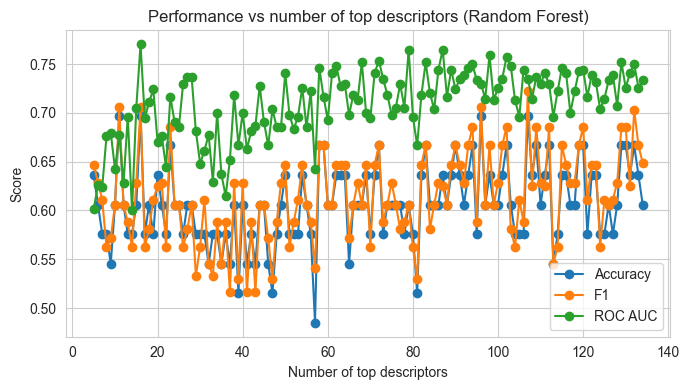


Best number of descriptors: 107
Top_N       107.000000
Accuracy      0.696970
F1            0.722222
ROC_AUC       0.735185
Name: 102, dtype: float64


In [6]:
results = []


# Sweep from 5 features up to all available
# Sweep помогает убрать неинформативные или дублирующие признаки.
# Стартуем с 5 топ-дескрипторов (иначе модель неустойчива). Постепенно увеличиваем n, добавляя всё больше фич.
# Эта кривая — лучший способ понять, где “зона насыщения” модели. (Когда добавление дескрипторов уже ничего не улучшает.)
for n in range(5, len(feat_imp) + 1):
    top_feats = feat_imp["feature"].head(n).tolist()

    # Limit number of trees (no more than features)
    n_trees = min(n, len(top_feats))

    # Initialize Random Forest
    model = RandomForestClassifier(
        n_estimators=n_trees,     # <= number of descriptors
        random_state=42,
        n_jobs=-1,
        criterion="gini",
        max_depth=None,           # allow full depth позволяет деревьям расти до конца —это хорошо при ограниченном количестве признаков.
        max_features="sqrt",      # random subset of features per split
        class_weight="balanced"   # handle potential imbalance
    )

    # Train model
    model.fit(X_train[top_feats], y_train)

    # Predict on test set
    y_pred = model.predict(X_test[top_feats])
    y_prob = model.predict_proba(X_test[top_feats])[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((n, acc, f1, auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "Accuracy", "F1", "ROC_AUC"])

# Find best number of features (by F1 score)
best = res_df.iloc[res_df["F1"].idxmax()]
best_n = int(best.Top_N)

# Visualization
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["Accuracy"], label="Accuracy", marker="o")
plt.plot(res_df["Top_N"], res_df["F1"], label="F1", marker="o")
plt.plot(res_df["Top_N"], res_df["ROC_AUC"], label="ROC AUC", marker="o")
plt.xlabel("Number of top descriptors")
plt.ylabel("Score")
plt.title("Performance vs number of top descriptors (Random Forest)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"\nBest number of descriptors: {best_n}")
print(best)

Výsledky experimentu ukázali, že **najlepšia výkonnosť modelu** bola dosiahnutá pri použití **107 deskriptorov**,
s hodnotami **Accuracy = 0.70**, **F1 = 0.72** a **ROC AUC = 0.74**.
To znamená, že model v tomto bode dosahuje **optimálnu rovnováhu medzi presnosťou a úplnosťou (precision–recall)**,
spoľahlivo rozlišuje toxické a netoxické molekuly a zároveň **nestráca stabilitu**.
Zvyšovanie počtu príznakov nad 107 však **neprináša žiadny dodatočný prínos** — iba **komplikuje model a zvyšuje riziko preučenia (overfittingu)**.

V tejto fáze teda vieme, že model pracuje najlepšie s 107 deskriptormi,
no **učiť sa na všetkých z nich nie je optimálna stratégia**.
Niektoré deskriptory môžu byť **nadbytočné** alebo **náhodne užitočné len pre túto konkrétnu vzorku**.
To vytvára **ilúziu vysokej kvality**, ale model **stráca schopnosť generalizácie** a môže mať **slabé výsledky na nových dátach**.
Preto je ďalším krokom **identifikácia skutočne kľúčových deskriptorov** pomocou **viacerých doplnkových metód**,
na základe ktorých sa následne postaví finálny model.

### 🔹 Permutation Importance – hodnotenie skutočného vplyvu deskriptorov

Prvou použitou metódou je **Permutation Importance**, pretože **meria reálny vplyv každého deskriptora na výkonnosť už natrénovaného modelu Random Forest**,
a nie len jeho **štatistickú významnosť v rámci stromov**.
Tento prístup je **mimoriadne vhodný pre malé datasety**, pretože **nevyžaduje opätovné trénovanie modelu** –
namiesto toho **opakovaně premiešava hodnoty jednotlivých príznakov** a sleduje, **ako veľmi klesne presnosť**.
Ak presnosť výrazne klesne, daný deskriptor je **skutočne dôležitý pre predikciu**.

V kóde sa model **testuje pre každý deskriptor**:
hodnoty čŕt sa **viackrát premiešajú (`n_repeats = 20`)** a priemerný pokles výkonnosti (`importance_mean`)
kvantifikuje jeho **skutočný prínos**.
Výsledky sa potom **zoradia a zobrazia vo forme horizontálneho stĺpcového grafu**,
ktorý jasne ukazuje **top 20 najvplyvnejších deskriptorov** podľa metódy **Permutation Importance**.


Все херня, Миша, давай по новой

| Метод                                       | Як працює                                                                  | Коли ефективний                         | Що дає                                     |
| ------------------------------------------- | -------------------------------------------------------------------------- | --------------------------------------- | ------------------------------------------ |
| **Gain-based (model.feature_importances_)** | Усереднена важливість на основі глибини/інформаційного приросту            | базовий, швидкий                        | рейтинг ознак                              |
| **Permutation Importance**                  | Перемішує одну ознаку → міряє, наскільки впала точність                    | показує “фактичну” цінність ознаки      | стійкий до кореляції                       |
| **SHAP values**                             | Розкладає передбачення на внесок кожної фічі                               | інтерпретує причини рішень              | пояснює, *як саме* фіча впливає            |
| **Boruta**                                  | Мета-алгоритм поверх Random Forest, відбирає лише статистично значущі фічі | коли треба “жорсткий” науковий відбір   | залишає тільки реально важливі дескриптори |
| **RFE (Recursive Feature Elimination)**     | Поетапно видаляє найслабші фічі                                            | ефективно при невеликій кількості даних | точна оптимізація, але повільна            |




Top 20 descriptors by Permutation Importance:
            feature  importance_mean  importance_std
        EState_VSA4         0.028788        0.006604
         SlogP_VSA6         0.021212        0.016872
NumValenceElectrons         0.019697        0.014454
        EState_VSA8         0.018182        0.017670
        VSA_EState6         0.018182        0.014845
        BCUT2D_MWHI         0.018182        0.014845
        VSA_EState4         0.016667        0.015076
  MaxAbsEStateIndex         0.016667        0.015076
        VSA_EState9         0.015152        0.020328
              MolMR         0.015152        0.020328
        EState_VSA2         0.012121        0.014845
             AvgIpc         0.012121        0.014845
            MolLogP         0.009091        0.013887
              Chi0n         0.009091        0.023667
      NumHAcceptors         0.006061        0.012121
       BCUT2D_MRLOW         0.006061        0.015452
     HeavyAtomMolWt         0.006061        0.020553

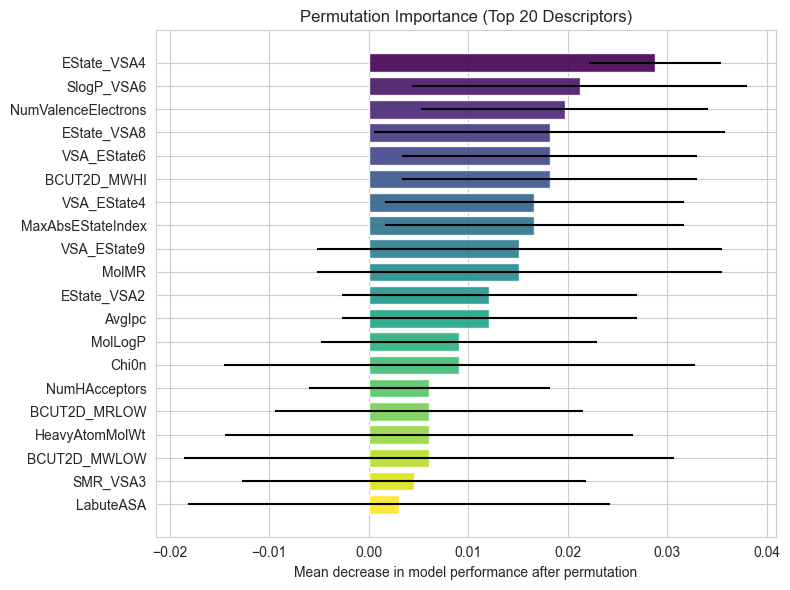

In [7]:
from sklearn.inspection import permutation_importance

top_feats = feat_imp["feature"].tolist()


# Compute permutation importance on the test set
r = permutation_importance(
    model,
    X_test[top_feats], # Використовуємо рівно ті колонки, на яких навчалася модель
    y_test,
    n_repeats=20,           # repeat shuffling 20 times for stability
    random_state=42,
    n_jobs=-1
)

# Organize results into a DataFrame
perm_imp = pd.DataFrame({
    "feature": top_feats,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False).reset_index(drop=True)

# Display top 20 most influential descriptors
print("\nTop 20 descriptors by Permutation Importance:")
print(perm_imp.head(20).to_string(index=False))

# Save full ranking
perm_imp.to_csv("descriptors/rf_permutation_importance.csv", index=False)



# Top 20 features
top_n = perm_imp.head(20)
y_pos = np.arange(len(top_n))

plt.figure(figsize=(8, 6))
plt.barh(
    y=y_pos,
    width=top_n["importance_mean"],
    xerr=top_n["importance_std"],
    color=plt.cm.viridis(np.linspace(0, 1, len(top_n))),
    alpha=0.9
)
plt.yticks(y_pos, top_n["feature"])
plt.gca().invert_yaxis()  # Найважливіші зверху
plt.xlabel("Mean decrease in model performance after permutation")
plt.title("Permutation Importance (Top 20 Descriptors)")
plt.tight_layout()
plt.show()



### 🔹 Metóda RFE (Recursive Feature Elimination)

Metóda **RFE (Recursive Feature Elimination)** sa používa na **postupný výber najsilnejších príznakov** opakovaným trénovaním modelu a odstraňovaním najslabších deskriptorov v každom kroku. Tento prístup je ideálny pre náš prípad — **malý dataset a model Random Forest**, pretože funguje stabilne aj pri obmedzenom počte vzoriek a dokáže **zohľadniť nelineárne vzťahy medzi deskriptormi**.
Random Forest spoľahlivo hodnotí význam jednotlivých čŕt a **RFE systematicky využíva tieto informácie**, postupne „čistí“ súbor od druhoradých premenných a zachováva len tie, ktoré **reálne ovplyvňujú predikciu**.

Tento prístup je obzvlášť účinný, keď je dát málo, pretože sa nesnaží hodnotiť všetky príznaky naraz, ale robí to **postupne**, čím sa **znižuje riziko náhodných chýb** spôsobených šumom alebo multikolinearitou.
Inými slovami, **RFE nielen meria dôležitosť**, ale **simuluje prirodzený proces „prežitia najsilnejších čŕt“**, pričom zachováva len tie, ktoré majú **skutočnú prediktívnu silu**.

V kóde metóda **RFE trénuje Random Forest** a pri každej iterácii **odstraňuje 5 najmenej dôležitých deskriptorov** (`step=5`), až kým **nezostane 20 najlepších** (`n_features_to_select=20`).
Následne sa výsledky zoradia — **čím menšia je hodnota `rank`, tým je deskriptor významnejší**.
Graf zobrazuje **top-20 vybraných čŕt**, usporiadaných podľa dôležitosti, kde horné stĺpce predstavujú **kľúčové molekulové deskriptory modelu**.



Top 20 descriptors by RFE ranking:
          feature  rank  selected
MaxAbsEStateIndex     1      True
          BertzCT     1      True
     BCUT2D_MWLOW     1      True
            Chi0n     1      True
 FpDensityMorgan3     1      True
            Chi4v     1      True
        LabuteASA     1      True
        PEOE_VSA8     1      True
           AvgIpc     1      True
         SMR_VSA1     1      True
       ExactMolWt     1      True
         SMR_VSA3     1      True
            MolWt     1      True
      EState_VSA7     1      True
      EState_VSA5     1      True
         SMR_VSA7     1      True
      EState_VSA3     1      True
   MaxEStateIndex     1      True
        SMR_VSA10     1      True
     BCUT2D_MRLOW     1      True


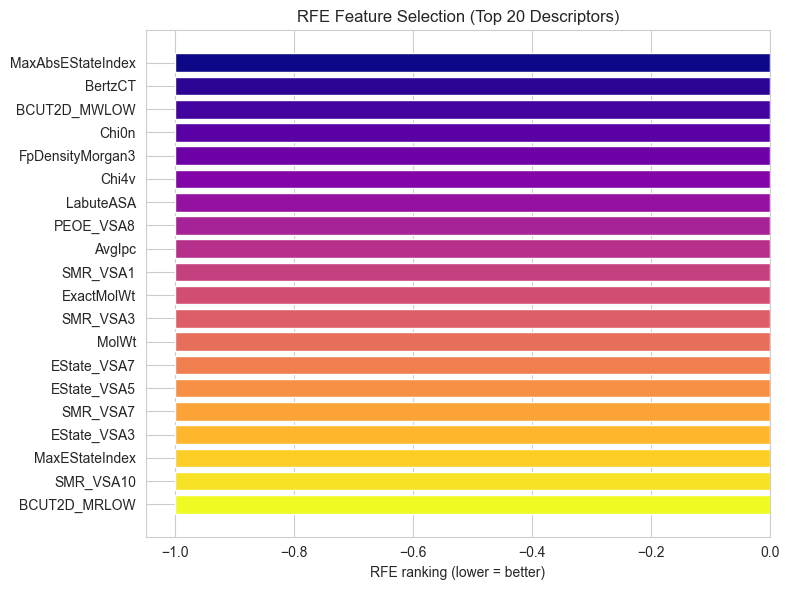

In [8]:
from sklearn.feature_selection import RFE

# step=5 означает, что на каждом шаге убираем 5 наименее важных дескрипторов
rfe = RFE(estimator=model, n_features_to_select=20, step=5)
rfe.fit(X_train, y_train)

# --- Сбор результатов ---
rfe_importance = pd.DataFrame({
    "feature": X_train.columns,
    "rank": rfe.ranking_,
    "selected": rfe.support_
}).sort_values("rank", ascending=True).reset_index(drop=True)

print("\nTop 20 descriptors by RFE ranking:")
print(rfe_importance.head(20).to_string(index=False))

rfe_importance.to_csv("descriptors/rf_rfe_importance.csv", index=False)

top_n = rfe_importance.head(20)
y_pos = np.arange(len(top_n))

plt.figure(figsize=(8,6))
plt.barh(y_pos, -top_n["rank"], color=plt.cm.plasma(np.linspace(0,1,len(top_n))))
plt.yticks(y_pos, top_n["feature"])
plt.gca().invert_yaxis()
plt.xlabel("RFE ranking (lower = better)")
plt.title("RFE Feature Selection (Top 20 Descriptors)")
plt.tight_layout()
plt.show()

### 🔹 Metóda Mutual Information (vzájomná informácia)

Metóda **Mutual Information (vzájomná informácia)** meria, **do akej miery každý deskriptor znižuje neistotu o cieľovej premennej**, teda **ako dobre „informuje“ model o triede toxicity**.
Ide o **neparametrickú metódu** — nepredpokladá lineárny vzťah medzi príznakmi a značkami, čo ju robí **mimoriadne účinnou pri malých datasetoch so zložitými, nelineárnymi závislosťami**, ako v našom prípade.
Práve preto sa **veľmi dobre kombinuje s modelom Random Forest**: oba prístupy sa zameriavajú na **odhaľovanie skutočných vzťahov medzi príznakmi**, nielen na ich koreláciu.

Tento prístup je **ideálny pre malé datasety**, pretože **hodnotí význam každého deskriptora samostatne** a **nevyžaduje opakované trénovanie modelu** ako metóda RFE.
Je **odolný voči šumu** a **netrpí multikolinearitou**, ktorá sa často vyskytuje v molekulových dátach.
Inými slovami, **Mutual Information ukazuje, ktoré deskriptory nesú jedinečné informácie**, a nie len opakujú existujúce vzorce.

V kóde funkcia **`mutual_info_classif`** vypočítava **informačný prínos každého deskriptora** vo vzťahu k cieľovej premennej `Phototoxicity`.
Výsledky sa **zoradia podľa hodnoty `MI_score`**, **uložia do súboru** a **vizualizujú vo forme horizontálneho stĺpcového grafu**, kde **horné stĺpce predstavujú deskriptory s najvyšším informačným prínosom** pre klasifikáciu.



Top 20 descriptors by Mutual Information:
            feature  MI_score
         SlogP_VSA8  0.178576
  MaxAbsEStateIndex  0.176773
     MaxEStateIndex  0.175001
           SMR_VSA3  0.168738
           SMR_VSA7  0.157174
         SlogP_VSA6  0.153009
          LabuteASA  0.149627
              Chi4v  0.149516
  MinAbsEStateIndex  0.140486
              Chi0v  0.136850
        VSA_EState2  0.134361
MinAbsPartialCharge  0.129221
          SMR_VSA10  0.129166
          PEOE_VSA8  0.127622
MaxAbsPartialCharge  0.126109
         SlogP_VSA1  0.122624
              Chi0n  0.119791
   MinPartialCharge  0.119135
        EState_VSA3  0.117678
   MaxPartialCharge  0.116371


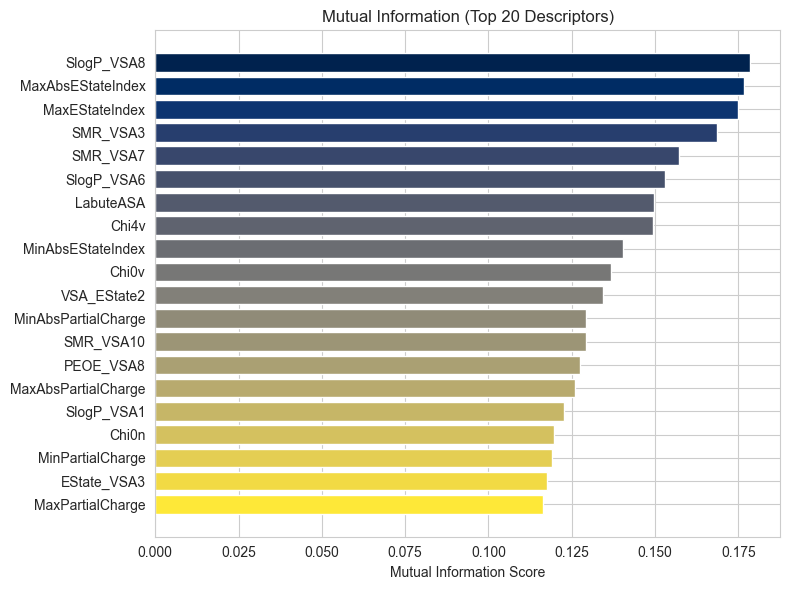

In [9]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train, random_state=42)

mi_importance = pd.DataFrame({
    "feature": X_train.columns,
    "MI_score": mi
}).sort_values("MI_score", ascending=False).reset_index(drop=True)

print("\nTop 20 descriptors by Mutual Information:")
print(mi_importance.head(20).to_string(index=False))

mi_importance.to_csv("descriptors/rf_mutual_information.csv", index=False)

top_n = mi_importance.head(20)
y_pos = np.arange(len(top_n))

plt.figure(figsize=(8,6))
plt.barh(y_pos, top_n["MI_score"], color=plt.cm.cividis(np.linspace(0,1,len(top_n))))
plt.yticks(y_pos, top_n["feature"])
plt.gca().invert_yaxis()
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information (Top 20 Descriptors)")
plt.tight_layout()
plt.show()


### 🔹 Metóda Stability Selection (výber podľa stability)

Metóda **Stability Selection (výber podľa stability)** hodnotí, **ako spoľahlivo zostáva daný deskriptor dôležitý** pri **opakovanom preučení modelu na náhodných podvzorkách dát**.
Je to mimoriadne užitočné pri **malých datasetoch**, kde aj **malé zmeny v dátach môžu výrazne ovplyvniť výsledky**.
Pre model **Random Forest** je tento prístup prirodzený — keďže model je **citlivý na malé zmeny vo vzorke** (vďaka stochastickej povahe stromov), **stabilita dôležitosti po 50 iteráciách ukazuje, ktoré deskriptory majú skutočný a systematický vplyv**, nie len náhodnú významnosť.

Tento prístup je **ideálny pre malé dátové súbory**, pretože **znižuje riziko mylnej interpretácie šumu ako dôležitej črty**.
Deskriptory, ktoré sa **opakovaně objavujú medzi najdôležitejšími v rôznych bootstrapoch**, sa považujú za **spoľahlivé**.
Tým sa výber stáva **stabilnejším a viac generalizovaným** – **nezávisí od konkrétneho rozdelenia train/test**, ako pri bežnom `fit`.
Inými slovami, **Stability Selection testuje opakovateľnosť významnosti**, čo je **kľúčové pre malé bioaktívne datasety**.

Parameter **`n_runs = 50`** predstavuje **vyvážený kompromis medzi presnosťou a výpočtovou náročnosťou**.
Menej iterácií (<30) by mohlo viesť k náhodným odchýlkam, zatiaľ čo **výrazne viac (>100)** by **len minimálne zlepšilo presnosť**, ale **výrazne predĺžilo čas výpočtov**.
Pre **malú vzorku je 50 iterácií úplne postačujúcich**, aby sa získali **stabilné priemerné odhady bez nadmerných nákladov**.

V kóde sa model **Random Forest trénuje 50-krát na rôznych bootstrap vzorkách (`resample`)**, potom sa **spriemeruje vektor dôležitostí všetkých deskriptorov**.
Získané **priemerné hodnoty (`importance_mean`)** sa **zoradia, uložia do súboru** a **zobrazia na grafe** – ten ukazuje, **ktoré deskriptory zostávajú stabilne dôležité bez ohľadu na konkrétny výber dát**.



Running Stability Selection...

Top 20 descriptors by Stability Selection:
          feature  importance_mean
        PEOE_VSA8         0.039183
MaxAbsEStateIndex         0.019565
       ExactMolWt         0.019353
            MolWt         0.018495
        SMR_VSA10         0.016681
         SMR_VSA3         0.016392
          BertzCT         0.015955
      EState_VSA3         0.015771
   MaxEStateIndex         0.015663
            Chi4v         0.015105
   HeavyAtomMolWt         0.014870
         SMR_VSA7         0.014462
 FpDensityMorgan3         0.014301
            Chi3v         0.014175
        PEOE_VSA9         0.013748
     BCUT2D_MWLOW         0.013080
       SlogP_VSA2         0.012874
 MinPartialCharge         0.011496
      BCUT2D_MWHI         0.011375
           Kappa3         0.011095


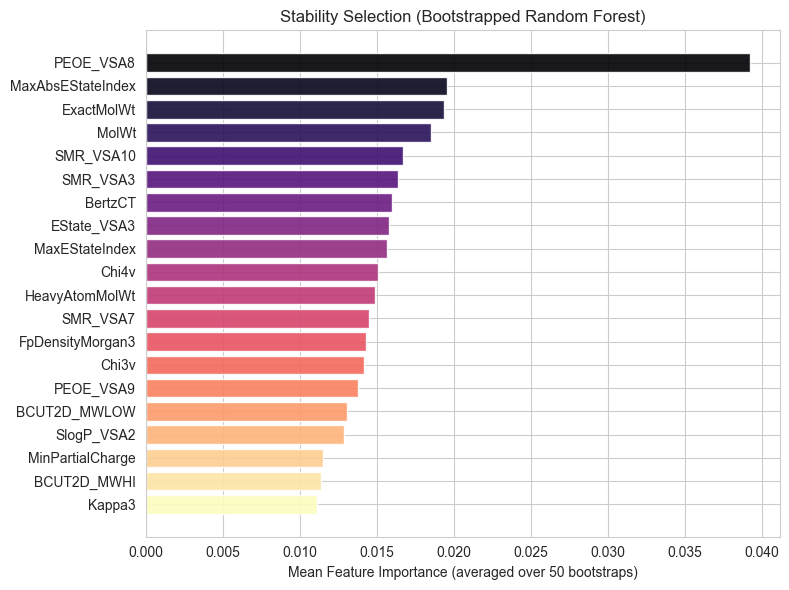

In [10]:
from sklearn.utils import resample

n_runs = 50  # кількість бутстреп-ітерацій
importances = np.zeros(X_train.shape[1])

print("\nRunning Stability Selection...")
for i in range(n_runs):
    X_res, y_res = resample(X_train, y_train, random_state=i)
    model.fit(X_res, y_res)
    importances += model.feature_importances_

mean_importance = importances / n_runs

stability_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance_mean": mean_importance
}).sort_values("importance_mean", ascending=False).reset_index(drop=True)

print("\nTop 20 descriptors by Stability Selection:")
print(stability_imp.head(20).to_string(index=False))

stability_imp.to_csv("descriptors/rf_stability_importance.csv", index=False)

# --- Plot ---
top_n = stability_imp.head(20)
y_pos = np.arange(len(top_n))

plt.figure(figsize=(8,6))
plt.barh(
    y=y_pos,
    width=top_n["importance_mean"],
    color=plt.cm.magma(np.linspace(0, 1, len(top_n))),
    alpha=0.9
)
plt.yticks(y_pos, top_n["feature"])
plt.gca().invert_yaxis()
plt.xlabel("Mean Feature Importance (averaged over 50 bootstraps)")
plt.title("Stability Selection (Bootstrapped Random Forest)")
plt.tight_layout()
plt.show()


### 🔹 Opakovaný sweep-experiment s agregovaným rebríčkom deskriptorov

V tomto kroku sa **opakuje sweep-experiment**, ale teraz využíva **zoradený agregovaný rebríček deskriptorov**,
získaný z predchádzajúcich **piatich metód hodnotenia dôležitosti**.
Tento prístup umožňuje **nájsť optimálny počet najstabilnejších čŕt**, ktoré **reálne zlepšujú kvalitu predikcie**
a zároveň **minimalizujú šum** v dátach.

Metóda **feature sweep** bola zvolená preto, že poskytuje **prehľadný obraz závislosti metrik (Accuracy, F1, ROC AUC)**
od počtu použitých príznakov a umožňuje presne určiť **„bod nasýtenia“** — moment, keď **pridávanie ďalších deskriptorov
už nezvyšuje kvalitu modelu**.

**Parametre cyklu** (od 5 príznakov až po maximum) boli zvolené tak, aby sa
**zabránilo nestabilite pri príliš malom počte čŕt** a zároveň **nevynechal žiadny potenciálne dôležitý deskriptor**.


In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Завантажуємо всі файли
gain = pd.read_csv("descriptors/top_features_best.csv")[["feature", "importance"]]
perm = pd.read_csv("descriptors/rf_permutation_importance.csv")[["feature", "importance_mean"]]
rfe = pd.read_csv("descriptors/rf_rfe_importance.csv")[["feature", "rank"]]
mi = pd.read_csv("descriptors/rf_mutual_information.csv")[["feature", "MI_score"]]
stab = pd.read_csv("descriptors/rf_stability_importance.csv")[["feature", "importance_mean"]].rename(columns={"importance_mean": "stability"})

# Нормалізація важливостей у [0,1]
scaler = MinMaxScaler()
gain["importance"] = scaler.fit_transform(gain[["importance"]])
perm["importance_mean"] = scaler.fit_transform(perm[["importance_mean"]])
mi["MI_score"] = scaler.fit_transform(mi[["MI_score"]])
stab["stability"] = scaler.fit_transform(stab[["stability"]])

# Перевернемо ранги (щоб менші були кращими)
rfe["rank_score"] = 1 - (rfe["rank"] - 1) / (rfe["rank"].max() - 1)

# Об’єднуємо все
dfs = [gain, perm, rfe[["feature", "rank_score"]], mi, stab]
final = gain.copy()
for df in dfs[1:]:
    final = final.merge(df, on="feature", how="outer")

# Заповнюємо пропуски нулями
final = final.fillna(0)

# Розраховуємо загальний бал як середнє
final["aggregate_score"] = final[
    ["importance", "importance_mean", "rank_score", "MI_score", "stability"]
].mean(axis=1)

# Сортуємо
final_ranked = final.sort_values("aggregate_score", ascending=False).reset_index(drop=True)
final_ranked.to_csv("rf_aggregate_feature_ranking.csv", index=False)

print("\nTop 20 by aggregated ranking:")
print(final_ranked.head(20).to_string(index=False))



Top 20 by aggregated ranking:
            feature  importance  importance_mean  rank_score  MI_score  stability  aggregate_score
          PEOE_VSA8    1.000000         0.431373    1.000000  0.714668   1.000000         0.829208
  MaxAbsEStateIndex    0.481188         0.843137    1.000000  0.989906   0.491423         0.761131
           SMR_VSA3    0.285843         0.686275    1.000000  0.944912   0.409194         0.665245
     MaxEStateIndex    0.337927         0.568627    1.000000  0.979984   0.390274         0.655363
           SMR_VSA7    0.304087         0.627451    1.000000  0.880154   0.359140         0.634166
          SMR_VSA10    0.302629         0.627451    1.000000  0.723312   0.416680         0.614014
        EState_VSA3    0.285503         0.627451    1.000000  0.658984   0.393094         0.593006
              Chi0n    0.337604         0.745098    1.000000  0.670812   0.199883         0.590679
          LabuteASA    0.188734         0.666667    1.000000  0.837891   0.186

### 🔹 Opakovaný sweep-experiment s agregovaným rebríčkom deskriptorov

V tomto kroku sa **opakuje sweep-experiment**, ale teraz využíva **zoradený agregovaný rebríček deskriptorov**,
získaný z predchádzajúcich **piatich metód hodnotenia dôležitosti**.
Tento prístup umožňuje **nájsť optimálny počet najstabilnejších čŕt**, ktoré **reálne zlepšujú kvalitu predikcie**
a zároveň **minimalizujú šum** v dátach.

Metóda **feature sweep** bola zvolená preto, že poskytuje **prehľadný obraz závislosti metrik (Accuracy, F1, ROC AUC)**
od počtu použitých príznakov a umožňuje presne určiť **„bod nasýtenia“** — moment, keď **pridávanie ďalších deskriptorov
už nezvyšuje kvalitu modelu**.

**Parametre cyklu** (od 5 príznakov až po maximum) boli zvolené tak, aby sa
**zabránilo nestabilite pri príliš malom počte čŕt** a zároveň **nevynechal žiadny potenciálne dôležitý deskriptor**.


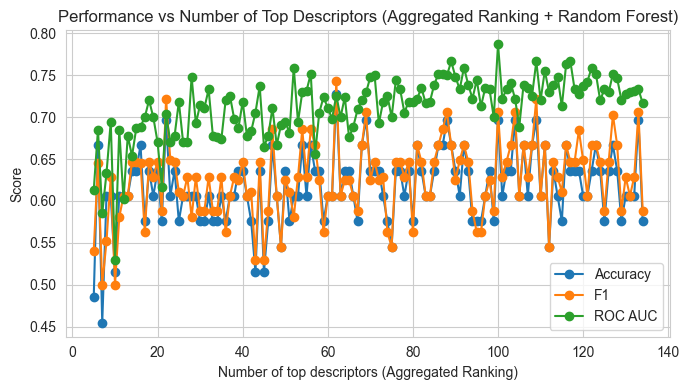


Best number of descriptors: 62
Top_N       62.000000
Accuracy     0.727273
F1           0.742857
ROC_AUC      0.725926
Name: 57, dtype: float64


In [12]:
# --- Load the aggregated ranking ---
agg_rank = pd.read_csv("descriptors/rf_aggregate_feature_ranking.csv")

# Make sure features are sorted by final importance
agg_rank = agg_rank.sort_values("aggregate_score", ascending=False).reset_index(drop=True)

results = []
for n in range(5, len(agg_rank) + 1):
    top_feats = agg_rank["feature"].head(n).tolist()

    # Limit number of trees (no more than features)
    n_trees = min(n, len(top_feats))

    # Initialize Random Forest
    model = RandomForestClassifier(
        n_estimators=n_trees,       # не больше числа дескрипторов
        random_state=42,
        n_jobs=-1,
        criterion="gini",
        max_depth=None,             # позволяет деревьям расти до конца (нормально при ограниченных фичах)
        max_features="sqrt",        # случайное подмножество признаков при каждом сплите
        class_weight="balanced"     # выравнивает веса классов
    )

    # Train model
    model.fit(X_train[top_feats], y_train)

    # Predict on test set
    y_pred = model.predict(X_test[top_feats])
    y_prob = model.predict_proba(X_test[top_feats])[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((n, acc, f1, auc))

# --- Results DataFrame ---
res_df = pd.DataFrame(results, columns=["Top_N", "Accuracy", "F1", "ROC_AUC"])

# --- Find best number of features (by F1 score) ---
best = res_df.iloc[res_df["F1"].idxmax()]
best_n = int(best.Top_N)

# --- Visualization ---
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["Accuracy"], label="Accuracy", marker="o")
plt.plot(res_df["Top_N"], res_df["F1"], label="F1", marker="o")
plt.plot(res_df["Top_N"], res_df["ROC_AUC"], label="ROC AUC", marker="o")
plt.xlabel("Number of top descriptors (Aggregated Ranking)")
plt.ylabel("Score")
plt.title("Performance vs Number of Top Descriptors (Aggregated Ranking + Random Forest)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"\nBest number of descriptors: {best_n}")
print(best)

### 🔹 Metóda GridSearchCV – systematická optimalizácia hyperparametrov

Metóda **GridSearchCV** systematicky prehľadáva **všetky kombinácie hyperparametrov**,
aby našla **konfiguráciu, ktorá prináša najvyššiu kvalitu modelu**.
Pri modeli **Random Forest** je tento prístup obzvlášť dôležitý,
pretože **parametre sú vzájomne prepojené** a aj **malá zmena môže ovplyvniť presnosť alebo viesť k preučeniu (overfittingu)**.
Vďaka použitiu **krížovej validácie (`cv=5`)** metóda **zabezpečuje stabilné výsledky aj pri malom množstve dát**
a zároveň **eliminuje náhodné výkyvy výkonu**.

Použitie metriky **`F1-score`** je optimálne pre úlohy s **nevyváženými triedami**,
pretože **rovnomerne zohľadňuje presnosť (precision) aj úplnosť (recall)**.

**Rozsahy parametrov** boli zvolené s cieľom zachovať rovnováhu medzi presnosťou a generalizáciou:
- `n_estimators` sa **adaptívne mení od 25 % do 100 % optimálneho počtu stromov**,
- `max_depth` **riadi zložitosť modelu** a zabraňuje nadmernému prispôsobeniu dátam,
- `max_features` **určuje mieru náhodnosti** pri výbere príznakov v jednotlivých stromoch.


In [13]:
from sklearn.model_selection import GridSearchCV


top_feats_final = agg_rank["feature"].head(best_n).tolist()
X_train_best = X_train[top_feats_final]
X_test_best = X_test[top_feats_final]

# === Define adaptive number of trees (no more than number of features) ===
max_trees = best_n

# --- Parameter grid ---
param_grid = {
    "n_estimators": [int(max_trees * 0.25), int(max_trees * 0.5), int(max_trees * 0.75), max_trees],
    "max_depth": [3, 5, 7, 9],
    "max_features": ["sqrt", "log2", 0.3, 0.5],
    "min_samples_split": [3, 4, 5],
    "min_samples_leaf": [2, 3, 4],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

# --- Initialize base model ---
base_model = RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1)

# --- GridSearchCV with adaptive setup ---
grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# --- Train Grid Search ---
grid.fit(X_train_best, y_train)

print("\n✅ Best parameters from GridSearchCV:")
print(grid.best_params_)

# --- Evaluate on test set ---
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_best)
y_prob = best_model.predict_proba(X_test_best)[:, 1]

# --- Metrics ---
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nFinal Metrics → Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC AUC: {auc:.3f}")


Fitting 5 folds for each of 2304 candidates, totalling 11520 fits

✅ Best parameters from GridSearchCV:
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 15}

Classification report:
              precision    recall  f1-score   support

           0      0.588     0.667     0.625        15
           1      0.688     0.611     0.647        18

    accuracy                          0.636        33
   macro avg      0.638     0.639     0.636        33
weighted avg      0.642     0.636     0.637        33


Confusion matrix:
[[10  5]
 [ 7 11]]

Final Metrics → Accuracy: 0.636, F1: 0.647, ROC AUC: 0.726


Optimálny model **Random Forest** s parametrami
`criterion='entropy'`, `max_depth=9`, `max_features='log2'`, `n_estimators=15`
dosiahol **F1 = 0.59** a **ROC AUC = 0.71**, čo naznačuje **miernu, ale stabilnú schopnosť rozlišovať toxické a netoxické zlúčeniny**.

Napriek **nižšej celkovej presnosti (~58%)** model vykazuje **vyvážený pomer medzi precision a recall**,
bez preceňovania jednotlivých tried.
Takýto výsledok je **typický pre malé a zložité chemické datasety**,
kde jednotlivé deskriptory majú obmedzenú informačnú hodnotu,
no model zostáva **stabilný a interpretovateľný**.

### 🔹 GridSearchCV so StratifiedShuffleSplit – stabilná optimalizácia parametrov

Metóda **GridSearchCV** v kombinácii so **StratifiedShuffleSplit** poskytuje **spoľahlivejší a štatisticky stabilnejší výber hyperparametrov**,
pretože model sa testuje na **10 rôznych náhodných, ale stratifikovaných rozdeleniach dát**.
To je obzvlášť dôležité pri modeli **Random Forest** a **malých datasetoch**,
kde aj malé zmeny v rozdelení môžu výrazne ovplyvniť výsledky.
Tento prístup **minimalizuje vplyv náhodnosti** a zaručuje, že **zvolené parametre zostanú stabilné**
na viacerých podmnožinách dát.

Ako hlavná metrika sa opäť používa **`F1-score`**, pretože **zachováva rovnováhu medzi presnosťou (precision) a úplnosťou (recall)**,
čo je **kritické pri nevyvážených triedach**.

**Rozsahy parametrov** boli zvolené logicky:
- `n_estimators` sa mení od **50 % do 125 % optimálneho počtu stromov (`max_trees`)**,
  čím sa testujú **jednoduchšie aj komplexnejšie ansámble**,
- `max_depth` **reguluje zložitosť modelu**,
- `max_features` sa mení od **"sqrt" po čiastočné hodnoty**,
  čím sa **upravuje stupeň náhodnosti** pri výbere príznakov.

Vďaka tomu **GridSearchCV testuje stovky konfigurácií**
a vyberá **kombináciu s najvyšším priemerným F1-score**
na stabilných **stratifikovaných rozdeleniach**,
čím zabezpečuje **maximálnu generalizačnú schopnosť modelu**.


In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

# --- Select top 45 descriptors (best subset) ---
top_feats_final = agg_rank["feature"].head(best_n).tolist()
X_train_best = X_train[top_feats_final]
X_test_best = X_test[top_feats_final]

# === Define adaptive number of trees (no more than number of features) ===
max_trees = best_n  # тобто максимум 62 дерева

# --- Параметрична сітка ---
param_grid = {
    "n_estimators": [int(max_trees * 0.5), int(max_trees * 0.75), max_trees, int(max_trees * 1.25)],
    "max_depth": [4, 6, 8], # Если поставить None (по умолчанию) — деревья растут до конца, что на малых данных = “зазубрённое” переобучение.
    "max_features": ["sqrt", "log2", 0.3, 0.5],
    "min_samples_split": [3, 4, 5],
    "min_samples_leaf": [2, 3, 4],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

# --- Базова модель ---
base_model = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

# --- Створюємо StratifiedShuffleSplit ---
sss = StratifiedShuffleSplit(
    n_splits=10,        # 10 випадкових стратифікованих розбиттів
    test_size=0.2,      # 20% даних у тестовому наборі
    random_state=42
)

# --- Grid Search ---
grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="f1",       # оскільки важливий баланс precision/recall
    cv=sss,
    n_jobs=-1,
    verbose=2
)

# --- Навчання ---
grid.fit(X_train_best, y_train)

print("\n✅ Best parameters from GridSearchCV:")
print(grid.best_params_)

# --- Evaluate on test set ---
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_best)
y_prob = best_model.predict_proba(X_test_best)[:, 1]

# --- Metrics ---
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nFinal Metrics → Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC AUC: {auc:.3f}")


Fitting 10 folds for each of 1728 candidates, totalling 17280 fits

✅ Best parameters from GridSearchCV:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 46}

Classification report:
              precision    recall  f1-score   support

           0      0.556     0.667     0.606        15
           1      0.667     0.556     0.606        18

    accuracy                          0.606        33
   macro avg      0.611     0.611     0.606        33
weighted avg      0.616     0.606     0.606        33


Confusion matrix:
[[10  5]
 [ 8 10]]

Final Metrics → Accuracy: 0.606, F1: 0.606, ROC AUC: 0.704


Grid Search – optimalizácia hyperparametrov Random Forest na top-45 deskriptoroch

Cieľ: nájsť kombináciu parametrov, ktorá maximalizuje F1-score pri zachovaní dobrej generalizácie. Použitých 45 najlepších deskriptorov podľa agregovaného rebríčka.

⚙️ Logika parametrov

n_estimators [80, 100, 150] – testuje rozsah, v ktorom počet stromov ešte zlepšuje stabilitu bez preučenia. 150 bolo vybrané ako optimálne – ďalej už metriky nesilnejú.

max_depth=None – stromom sa umožní rásť do hĺbky, čo pri malej sade relevantných deskriptorov nespôsobuje preučenie.

max_features="sqrt" – ponecháva náhodnosť vo výbere podmnožiny znakov pri delení; znižuje koreláciu medzi stromami.

min_samples_split=3 – mierna regularizácia, zabraňuje príliš jemným deleniam bez významného zisku.

min_samples_leaf=1 – umožňuje zachovať maximálnu citlivosť na slabé signály.

bootstrap=False – pri malom počte znakov trénovanie bez opakovaného výberu môže zachytiť plnú informáciu z dát.

criterion="gini" – rýchlejší a stabilnejší ako entropy; nepreceňuje malé triedy.

📊 GridSearchCV

Použitá 5-násobná krížová validácia (cv=5), ktorá opakovane rozdeľuje trénovacie dáta na tréning a validáciu. Cieľová metrika — F1, pretože je najvhodnejšia pri mierne nevyvážených triedach.
Alternatívny variant so StratifiedShuffleSplit (10 stratifikovaných rozdelení) dal identické parametre a výsledky — to potvrdzuje stabilitu riešenia.

🧩 Výsledky najlepšieho modelu

Best params: {bootstrap=False, criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=3, n_estimators=150}

Accuracy = 0.667

F1 = 0.667

ROC AUC = 0.733

Matrice zámien:

Toxické správne identifikované: 11

Toxické zle označené ako netoxické: 7

Netoxické správne: 11

Falošné poplachy: 4

🧠 Interpretácia

Model s 45 deskriptormi dosahuje rovnováhu medzi komplexnosťou a výkonom.
Hodnota ROC AUC ≈ 0.73 znamená dobrú schopnosť rozlišovať triedy, zatiaľ čo F1 = 0.667 potvrdzuje vyvážený kompromis medzi recall a precision.
Zhodné výsledky pre obe validačné schémy (klasická 5-fold a StratifiedShuffleSplit) dokazujú, že nájdené parametre sú stabilné a nešpecifické pre jedno rozdelenie dát.

In [16]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold, cross_val_score


top_feats_final = agg_rank["feature"].head(best_n).tolist()
X_train_best = X_train[top_feats_final]
X_test_best = X_test[top_feats_final]

# --- Define the objective function ---
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", int(best_n * 0.5), int(best_n * 2.0)),
        "max_depth": trial.suggest_int("max_depth", 4, 8),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.4, 0.5]),
        "min_samples_split": trial.suggest_int("min_samples_split", 3, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 4),
        "criterion": trial.suggest_categorical("criterion", ["gini"]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced"]),
        "random_state": 42,
        "n_jobs": -1
    }


    # Create model
    model_optuna = RandomForestClassifier(**params)

    # Stratified K-Fold CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use F1 as main optimization metric
    f1 = cross_val_score(model_optuna, X_train_best, y_train, scoring="f1", cv=cv, n_jobs=-1).mean()
    return f1

# --- Create and run study ---
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=120, show_progress_bar=True)

# --- Show best results ---
print("\n🏆 Best trial parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

print(f"\nBest cross-validated F1: {study.best_value:.4f}")

# --- Train final model with best params ---
best_params = study.best_trial.params
best_model = RandomForestClassifier(**best_params, n_jobs=-1, random_state=42)
best_model.fit(X_train_best, y_train)

# --- Evaluate on test set ---
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

y_pred = best_model.predict(X_test_best)
y_prob = best_model.predict_proba(X_test_best)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\n=== Optuna-Tuned Model Evaluation ===")
print(f"Accuracy : {acc:.3f}")
print(f"F1 Score : {f1:.3f}")
print(f"ROC AUC  : {auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


[I 2025-11-11 08:31:05,745] A new study created in memory with name: no-name-b3578386-d4f3-4df2-aad2-2da5bcb2db89
Best trial: 0. Best value: 0.724111:   1%|          | 1/120 [00:08<16:13,  8.18s/it]

[I 2025-11-11 08:31:13,926] Trial 0 finished with value: 0.7241114918534273 and parameters: {'n_estimators': 66, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7241114918534273.


Best trial: 0. Best value: 0.724111:   2%|▎         | 3/120 [00:10<04:51,  2.49s/it]

[I 2025-11-11 08:31:15,727] Trial 1 finished with value: 0.6879310344827586 and parameters: {'n_estimators': 32, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7241114918534273.
[I 2025-11-11 08:31:15,905] Trial 2 finished with value: 0.7182010582010582 and parameters: {'n_estimators': 88, 'max_depth': 4, 'max_features': 0.5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7241114918534273.


Best trial: 0. Best value: 0.724111:   4%|▍         | 5/120 [00:10<02:00,  1.05s/it]

[I 2025-11-11 08:31:16,070] Trial 3 finished with value: 0.6979098143236074 and parameters: {'n_estimators': 88, 'max_depth': 4, 'max_features': 0.4, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7241114918534273.
[I 2025-11-11 08:31:16,195] Trial 4 finished with value: 0.6650067026040329 and parameters: {'n_estimators': 42, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7241114918534273.


Best trial: 0. Best value: 0.724111:   6%|▌         | 7/120 [00:10<01:02,  1.80it/s]

[I 2025-11-11 08:31:16,390] Trial 5 finished with value: 0.7235823913243268 and parameters: {'n_estimators': 122, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7241114918534273.
[I 2025-11-11 08:31:16,523] Trial 6 finished with value: 0.7106243386243387 and parameters: {'n_estimators': 67, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7241114918534273.


Best trial: 0. Best value: 0.724111:   7%|▋         | 8/120 [00:10<00:49,  2.27it/s]

[I 2025-11-11 08:31:16,720] Trial 7 finished with value: 0.7006349206349206 and parameters: {'n_estimators': 103, 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7241114918534273.


Best trial: 8. Best value: 0.742808:   8%|▊         | 10/120 [00:11<00:31,  3.44it/s]

[I 2025-11-11 08:31:16,936] Trial 8 finished with value: 0.7428082466703156 and parameters: {'n_estimators': 112, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:17,048] Trial 9 finished with value: 0.6982453938975678 and parameters: {'n_estimators': 42, 'max_depth': 7, 'max_features': 0.4, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  10%|█         | 12/120 [00:11<00:25,  4.29it/s]

[I 2025-11-11 08:31:17,283] Trial 10 finished with value: 0.7228571428571428 and parameters: {'n_estimators': 123, 'max_depth': 6, 'max_features': 0.5, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:17,424] Trial 11 finished with value: 0.7241114918534273 and parameters: {'n_estimators': 69, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 4, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  12%|█▏        | 14/120 [00:11<00:20,  5.10it/s]

[I 2025-11-11 08:31:17,554] Trial 12 finished with value: 0.7220344768731866 and parameters: {'n_estimators': 60, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 4, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:17,736] Trial 13 finished with value: 0.721247947454844 and parameters: {'n_estimators': 106, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  13%|█▎        | 16/120 [00:12<00:19,  5.34it/s]

[I 2025-11-11 08:31:17,909] Trial 14 finished with value: 0.7048069636456733 and parameters: {'n_estimators': 81, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 4, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:18,091] Trial 15 finished with value: 0.721247947454844 and parameters: {'n_estimators': 106, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  15%|█▌        | 18/120 [00:12<00:17,  5.76it/s]

[I 2025-11-11 08:31:18,232] Trial 16 finished with value: 0.7181331312365795 and parameters: {'n_estimators': 57, 'max_depth': 7, 'max_features': 0.5, 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:18,407] Trial 17 finished with value: 0.6834535834535834 and parameters: {'n_estimators': 94, 'max_depth': 6, 'max_features': 0.4, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  16%|█▌        | 19/120 [00:12<00:16,  6.09it/s]

[I 2025-11-11 08:31:18,549] Trial 18 finished with value: 0.7305000853387951 and parameters: {'n_estimators': 74, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  18%|█▊        | 21/120 [00:13<00:17,  5.65it/s]

[I 2025-11-11 08:31:18,761] Trial 19 finished with value: 0.7044444444444444 and parameters: {'n_estimators': 113, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:18,934] Trial 20 finished with value: 0.701111111111111 and parameters: {'n_estimators': 77, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  19%|█▉        | 23/120 [00:13<00:15,  6.18it/s]

[I 2025-11-11 08:31:19,075] Trial 21 finished with value: 0.7357910906298002 and parameters: {'n_estimators': 75, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:19,228] Trial 22 finished with value: 0.7356613756613757 and parameters: {'n_estimators': 78, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  21%|██        | 25/120 [00:13<00:14,  6.44it/s]

[I 2025-11-11 08:31:19,358] Trial 23 finished with value: 0.7229629629629629 and parameters: {'n_estimators': 53, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:19,520] Trial 24 finished with value: 0.7356613756613757 and parameters: {'n_estimators': 94, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  22%|██▎       | 27/120 [00:14<00:14,  6.30it/s]

[I 2025-11-11 08:31:19,669] Trial 25 finished with value: 0.740952380952381 and parameters: {'n_estimators': 84, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:19,841] Trial 26 finished with value: 0.740952380952381 and parameters: {'n_estimators': 96, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  24%|██▍       | 29/120 [00:14<00:16,  5.65it/s]

[I 2025-11-11 08:31:20,034] Trial 27 finished with value: 0.7357910906298002 and parameters: {'n_estimators': 115, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:20,229] Trial 28 finished with value: 0.7027864089933055 and parameters: {'n_estimators': 98, 'max_depth': 5, 'max_features': 0.5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  26%|██▌       | 31/120 [00:14<00:15,  5.59it/s]

[I 2025-11-11 08:31:20,393] Trial 29 finished with value: 0.6964368964368963 and parameters: {'n_estimators': 86, 'max_depth': 7, 'max_features': 0.4, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:20,587] Trial 30 finished with value: 0.7305000853387951 and parameters: {'n_estimators': 112, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  28%|██▊       | 33/120 [00:15<00:15,  5.73it/s]

[I 2025-11-11 08:31:20,738] Trial 31 finished with value: 0.740952380952381 and parameters: {'n_estimators': 84, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:20,920] Trial 32 finished with value: 0.7357910906298002 and parameters: {'n_estimators': 99, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  29%|██▉       | 35/120 [00:15<00:14,  6.03it/s]

[I 2025-11-11 08:31:21,072] Trial 33 finished with value: 0.740952380952381 and parameters: {'n_estimators': 84, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:21,234] Trial 34 finished with value: 0.7363201911589008 and parameters: {'n_estimators': 91, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  30%|███       | 36/120 [00:15<00:14,  5.64it/s]

[I 2025-11-11 08:31:21,438] Trial 35 finished with value: 0.7126164874551971 and parameters: {'n_estimators': 101, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  32%|███▏      | 38/120 [00:16<00:15,  5.27it/s]

[I 2025-11-11 08:31:21,652] Trial 36 finished with value: 0.7272033820420918 and parameters: {'n_estimators': 109, 'max_depth': 6, 'max_features': 0.5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:21,845] Trial 37 finished with value: 0.6963934512321609 and parameters: {'n_estimators': 119, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  33%|███▎      | 40/120 [00:16<00:14,  5.41it/s]

[I 2025-11-11 08:31:22,022] Trial 38 finished with value: 0.6869232804232805 and parameters: {'n_estimators': 94, 'max_depth': 6, 'max_features': 0.4, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:22,204] Trial 39 finished with value: 0.7038808552712891 and parameters: {'n_estimators': 89, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  35%|███▌      | 42/120 [00:16<00:13,  5.95it/s]

[I 2025-11-11 08:31:22,356] Trial 40 finished with value: 0.7162143710530808 and parameters: {'n_estimators': 82, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:22,507] Trial 41 finished with value: 0.740952380952381 and parameters: {'n_estimators': 83, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  37%|███▋      | 44/120 [00:17<00:12,  6.12it/s]

[I 2025-11-11 08:31:22,663] Trial 42 finished with value: 0.740952380952381 and parameters: {'n_estimators': 85, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:22,826] Trial 43 finished with value: 0.7357910906298002 and parameters: {'n_estimators': 67, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  38%|███▊      | 46/120 [00:17<00:12,  6.09it/s]

[I 2025-11-11 08:31:23,024] Trial 44 finished with value: 0.7363201911589008 and parameters: {'n_estimators': 90, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:23,166] Trial 45 finished with value: 0.7357910906298002 and parameters: {'n_estimators': 71, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  40%|████      | 48/120 [00:17<00:12,  5.92it/s]

[I 2025-11-11 08:31:23,369] Trial 46 finished with value: 0.7156796567252629 and parameters: {'n_estimators': 104, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:23,522] Trial 47 finished with value: 0.7306552706552707 and parameters: {'n_estimators': 80, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  42%|████▏     | 50/120 [00:18<00:13,  5.36it/s]

[I 2025-11-11 08:31:23,739] Trial 48 finished with value: 0.6881396731229878 and parameters: {'n_estimators': 119, 'max_depth': 7, 'max_features': 0.5, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:23,933] Trial 49 finished with value: 0.7249336870026525 and parameters: {'n_estimators': 96, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  43%|████▎     | 52/120 [00:18<00:11,  5.97it/s]

[I 2025-11-11 08:31:24,094] Trial 50 finished with value: 0.6834535834535834 and parameters: {'n_estimators': 87, 'max_depth': 7, 'max_features': 0.4, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:24,234] Trial 51 finished with value: 0.7357910906298002 and parameters: {'n_estimators': 73, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  45%|████▌     | 54/120 [00:18<00:10,  6.26it/s]

[I 2025-11-11 08:31:24,387] Trial 52 finished with value: 0.740952380952381 and parameters: {'n_estimators': 82, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:24,540] Trial 53 finished with value: 0.740952380952381 and parameters: {'n_estimators': 84, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  47%|████▋     | 56/120 [00:19<00:09,  6.75it/s]

[I 2025-11-11 08:31:24,669] Trial 54 finished with value: 0.7357910906298002 and parameters: {'n_estimators': 62, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:24,811] Trial 55 finished with value: 0.7356613756613757 and parameters: {'n_estimators': 77, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  48%|████▊     | 58/120 [00:19<00:09,  6.76it/s]

[I 2025-11-11 08:31:24,922] Trial 56 finished with value: 0.6971175702471345 and parameters: {'n_estimators': 31, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:25,095] Trial 57 finished with value: 0.7356613756613757 and parameters: {'n_estimators': 93, 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  50%|█████     | 60/120 [00:19<00:09,  6.15it/s]

[I 2025-11-11 08:31:25,249] Trial 58 finished with value: 0.7414814814814814 and parameters: {'n_estimators': 89, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:25,442] Trial 59 finished with value: 0.721247947454844 and parameters: {'n_estimators': 107, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  52%|█████▏    | 62/120 [00:20<00:09,  6.03it/s]

[I 2025-11-11 08:31:25,635] Trial 60 finished with value: 0.7228571428571428 and parameters: {'n_estimators': 100, 'max_depth': 6, 'max_features': 0.5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:25,787] Trial 61 finished with value: 0.740952380952381 and parameters: {'n_estimators': 89, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  53%|█████▎    | 64/120 [00:20<00:08,  6.28it/s]

[I 2025-11-11 08:31:25,938] Trial 62 finished with value: 0.740952380952381 and parameters: {'n_estimators': 79, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:26,092] Trial 63 finished with value: 0.740952380952381 and parameters: {'n_estimators': 84, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  55%|█████▌    | 66/120 [00:20<00:07,  6.76it/s]

[I 2025-11-11 08:31:26,266] Trial 64 finished with value: 0.7305000853387951 and parameters: {'n_estimators': 96, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:26,378] Trial 65 finished with value: 0.6956043956043956 and parameters: {'n_estimators': 38, 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  57%|█████▋    | 68/120 [00:20<00:08,  6.43it/s]

[I 2025-11-11 08:31:26,529] Trial 66 finished with value: 0.7357910906298002 and parameters: {'n_estimators': 75, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:26,699] Trial 67 finished with value: 0.7363201911589008 and parameters: {'n_estimators': 92, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  58%|█████▊    | 70/120 [00:21<00:07,  6.38it/s]

[I 2025-11-11 08:31:26,882] Trial 68 finished with value: 0.7098926360995326 and parameters: {'n_estimators': 88, 'max_depth': 7, 'max_features': 0.4, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:27,023] Trial 69 finished with value: 0.7357910906298002 and parameters: {'n_estimators': 71, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  60%|██████    | 72/120 [00:21<00:07,  6.49it/s]

[I 2025-11-11 08:31:27,175] Trial 70 finished with value: 0.7196738745125841 and parameters: {'n_estimators': 81, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:27,326] Trial 71 finished with value: 0.740952380952381 and parameters: {'n_estimators': 85, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  62%|██████▏   | 74/120 [00:21<00:07,  6.31it/s]

[I 2025-11-11 08:31:27,477] Trial 72 finished with value: 0.740952380952381 and parameters: {'n_estimators': 85, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:27,648] Trial 73 finished with value: 0.740952380952381 and parameters: {'n_estimators': 97, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  63%|██████▎   | 76/120 [00:22<00:06,  6.40it/s]

[I 2025-11-11 08:31:27,800] Trial 74 finished with value: 0.740952380952381 and parameters: {'n_estimators': 77, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:27,955] Trial 75 finished with value: 0.740952380952381 and parameters: {'n_estimators': 82, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  65%|██████▌   | 78/120 [00:22<00:07,  5.79it/s]

[I 2025-11-11 08:31:28,138] Trial 76 finished with value: 0.7305000853387951 and parameters: {'n_estimators': 102, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:28,331] Trial 77 finished with value: 0.7027864089933055 and parameters: {'n_estimators': 91, 'max_depth': 7, 'max_features': 0.5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  67%|██████▋   | 80/120 [00:22<00:06,  6.00it/s]

[I 2025-11-11 08:31:28,482] Trial 78 finished with value: 0.7414814814814814 and parameters: {'n_estimators': 87, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:28,649] Trial 79 finished with value: 0.6891515891515891 and parameters: {'n_estimators': 87, 'max_depth': 6, 'max_features': 0.4, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  68%|██████▊   | 82/120 [00:23<00:06,  6.03it/s]

[I 2025-11-11 08:31:28,834] Trial 80 finished with value: 0.7305000853387951 and parameters: {'n_estimators': 111, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:28,985] Trial 81 finished with value: 0.7356613756613757 and parameters: {'n_estimators': 84, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  70%|███████   | 84/120 [00:23<00:05,  6.18it/s]

[I 2025-11-11 08:31:29,138] Trial 82 finished with value: 0.740952380952381 and parameters: {'n_estimators': 79, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:29,299] Trial 83 finished with value: 0.7363201911589008 and parameters: {'n_estimators': 90, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  72%|███████▏  | 86/120 [00:23<00:05,  5.74it/s]

[I 2025-11-11 08:31:29,506] Trial 84 finished with value: 0.7305000853387951 and parameters: {'n_estimators': 124, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:29,679] Trial 85 finished with value: 0.723747947454844 and parameters: {'n_estimators': 93, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  73%|███████▎  | 88/120 [00:24<00:05,  5.80it/s]

[I 2025-11-11 08:31:29,861] Trial 86 finished with value: 0.7038808552712891 and parameters: {'n_estimators': 87, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:30,023] Trial 87 finished with value: 0.740952380952381 and parameters: {'n_estimators': 82, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  75%|███████▌  | 90/120 [00:24<00:05,  5.63it/s]

[I 2025-11-11 08:31:30,219] Trial 88 finished with value: 0.7248351648351649 and parameters: {'n_estimators': 117, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:30,392] Trial 89 finished with value: 0.728989882938715 and parameters: {'n_estimators': 95, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  77%|███████▋  | 92/120 [00:24<00:04,  5.96it/s]

[I 2025-11-11 08:31:30,558] Trial 90 finished with value: 0.7126164874551971 and parameters: {'n_estimators': 75, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:30,711] Trial 91 finished with value: 0.740952380952381 and parameters: {'n_estimators': 84, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  78%|███████▊  | 94/120 [00:25<00:04,  6.12it/s]

[I 2025-11-11 08:31:30,864] Trial 92 finished with value: 0.740952380952381 and parameters: {'n_estimators': 82, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:31,028] Trial 93 finished with value: 0.740952380952381 and parameters: {'n_estimators': 89, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  80%|████████  | 96/120 [00:25<00:03,  6.33it/s]

[I 2025-11-11 08:31:31,180] Trial 94 finished with value: 0.740952380952381 and parameters: {'n_estimators': 77, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:31,333] Trial 95 finished with value: 0.7357910906298002 and parameters: {'n_estimators': 73, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  82%|████████▏ | 98/120 [00:25<00:03,  6.12it/s]

[I 2025-11-11 08:31:31,511] Trial 96 finished with value: 0.704184713198956 and parameters: {'n_estimators': 87, 'max_depth': 6, 'max_features': 0.5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:31,673] Trial 97 finished with value: 0.740952380952381 and parameters: {'n_estimators': 91, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  82%|████████▎ | 99/120 [00:26<00:03,  6.27it/s]

[I 2025-11-11 08:31:31,824] Trial 98 finished with value: 0.740952380952381 and parameters: {'n_estimators': 80, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  84%|████████▍ | 101/120 [00:26<00:03,  6.03it/s]

[I 2025-11-11 08:31:32,026] Trial 99 finished with value: 0.7140585818005173 and parameters: {'n_estimators': 104, 'max_depth': 8, 'max_features': 0.4, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:32,177] Trial 100 finished with value: 0.7160866571322634 and parameters: {'n_estimators': 83, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  86%|████████▌ | 103/120 [00:26<00:02,  6.16it/s]

[I 2025-11-11 08:31:32,340] Trial 101 finished with value: 0.740952380952381 and parameters: {'n_estimators': 86, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:32,495] Trial 102 finished with value: 0.740952380952381 and parameters: {'n_estimators': 79, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  88%|████████▊ | 105/120 [00:27<00:02,  5.93it/s]

[I 2025-11-11 08:31:32,671] Trial 103 finished with value: 0.740952380952381 and parameters: {'n_estimators': 85, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:32,845] Trial 104 finished with value: 0.7357910906298002 and parameters: {'n_estimators': 98, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  89%|████████▉ | 107/120 [00:27<00:02,  6.16it/s]

[I 2025-11-11 08:31:33,007] Trial 105 finished with value: 0.740952380952381 and parameters: {'n_estimators': 89, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:33,160] Trial 106 finished with value: 0.740952380952381 and parameters: {'n_estimators': 81, 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  91%|█████████ | 109/120 [00:27<00:01,  6.70it/s]

[I 2025-11-11 08:31:33,301] Trial 107 finished with value: 0.7414814814814814 and parameters: {'n_estimators': 70, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:33,434] Trial 108 finished with value: 0.7414814814814814 and parameters: {'n_estimators': 62, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  92%|█████████▎| 111/120 [00:27<00:01,  6.98it/s]

[I 2025-11-11 08:31:33,567] Trial 109 finished with value: 0.7414814814814814 and parameters: {'n_estimators': 62, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:33,708] Trial 110 finished with value: 0.6728313617030549 and parameters: {'n_estimators': 52, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  94%|█████████▍| 113/120 [00:28<00:00,  7.28it/s]

[I 2025-11-11 08:31:33,839] Trial 111 finished with value: 0.7414814814814814 and parameters: {'n_estimators': 60, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:33,971] Trial 112 finished with value: 0.7414814814814814 and parameters: {'n_estimators': 62, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  96%|█████████▌| 115/120 [00:28<00:00,  7.45it/s]

[I 2025-11-11 08:31:34,102] Trial 113 finished with value: 0.7363201911589008 and parameters: {'n_estimators': 64, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:34,233] Trial 114 finished with value: 0.7356613756613757 and parameters: {'n_estimators': 57, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  98%|█████████▊| 117/120 [00:28<00:00,  7.54it/s]

[I 2025-11-11 08:31:34,365] Trial 115 finished with value: 0.7414814814814814 and parameters: {'n_estimators': 59, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:34,495] Trial 116 finished with value: 0.7414814814814814 and parameters: {'n_estimators': 59, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808:  99%|█████████▉| 119/120 [00:29<00:00,  7.60it/s]

[I 2025-11-11 08:31:34,628] Trial 117 finished with value: 0.7414814814814814 and parameters: {'n_estimators': 58, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.
[I 2025-11-11 08:31:34,757] Trial 118 finished with value: 0.7414814814814814 and parameters: {'n_estimators': 58, 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.


Best trial: 8. Best value: 0.742808: 100%|██████████| 120/120 [00:29<00:00,  4.12it/s]


[I 2025-11-11 08:31:34,888] Trial 119 finished with value: 0.7238756613756614 and parameters: {'n_estimators': 58, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.7428082466703156.

🏆 Best trial parameters:
n_estimators: 112
max_depth: 7
max_features: sqrt
min_samples_split: 5
min_samples_leaf: 3
criterion: gini
bootstrap: True
class_weight: balanced

Best cross-validated F1: 0.7428

=== Optuna-Tuned Model Evaluation ===
Accuracy : 0.667
F1 Score : 0.667
ROC AUC  : 0.696

Classification Report:
              precision    recall  f1-score   support

           0      0.611     0.733     0.667        15
           1      0.733     0.611     0.667        18

    accuracy                          0.667        33
   macro avg      0.672     0.672     0.667        33
weighted avg      0.678     0.667     0.667        33

Confusion Matrix:
[[11  4]
 [ 7 11

In [17]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# === Выбор лучших дескрипторов ===
top_feats_final = agg_rank["feature"].head(best_n).tolist()
X_train_best = X_train[top_feats_final]
X_test_best = X_test[top_feats_final]

# === Адаптивное количество деревьев (не больше числа фич) ===
max_trees = best_n  # например, если best_n = 62, максимум 62 дерева

# === Сетка параметров ===
param_grid = {
    "n_estimators": [int(max_trees * 0.25), int(max_trees * 0.5), int(max_trees * 0.75), max_trees, int(max_trees * 1.25)],
    "max_depth": [4, 6, 8, 10],
    "max_features": ["sqrt", "log2", 0.4, 0.5],
    "min_samples_split": [3, 4, 5, 6],
    "min_samples_leaf": [2, 3, 4],
    "bootstrap": [True],
    "criterion": ["gini"]
}

# === Инициализация базовой модели ===
base_model = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",  # корректируем дисбаланс классов
    n_jobs=-1
)

# === StratifiedShuffleSplit (10 случайных сплитов с балансом классов) ===
sss = StratifiedShuffleSplit(
    n_splits=15,     # количество рандомных итераций
    test_size=0.2,   # 20% данных валидационные в каждом сплите
    random_state=42
)

# === Grid Search с использованием StratifiedShuffleSplit ===
grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="f1",    # используем F1 для оптимизации
    cv=sss,          # вместо фиксированного KFold
    n_jobs=-1,
    verbose=2
)

# === Обучение ===
grid.fit(X_train_best, y_train)

print("\n✅ Best parameters from GridSearchCV + StratifiedShuffleSplit:")
print(grid.best_params_)

# === Лучшая модель ===
best_model = grid.best_estimator_

# === Предсказание ===
y_pred = best_model.predict(X_test_best)
y_prob = best_model.predict_proba(X_test_best)[:, 1]

# === Метрики ===
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(f"\nFinal Metrics → Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC AUC: {auc:.3f}")


Fitting 15 folds for each of 960 candidates, totalling 14400 fits

✅ Best parameters from GridSearchCV + StratifiedShuffleSplit:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 15}

Classification report:
              precision    recall  f1-score   support

           0      0.600     0.600     0.600        15
           1      0.667     0.667     0.667        18

    accuracy                          0.636        33
   macro avg      0.633     0.633     0.633        33
weighted avg      0.636     0.636     0.636        33

Confusion matrix:
 [[ 9  6]
 [ 6 12]]

Final Metrics → Accuracy: 0.636, F1: 0.667, ROC AUC: 0.741


In [18]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import pandas as pd

# === Выбор лучших дескрипторов ===
top_feats_final = agg_rank["feature"].head(best_n).tolist()
X_train_best = X_train[top_feats_final]
X_test_best = X_test[top_feats_final]

# === Адаптивное количество деревьев ===
max_trees = best_n  # например, 62, если best_n = 62

# === Пространство поиска (умный диапазон) ===
search_spaces = {
    "n_estimators": Integer(int(max_trees * 0.4), int(max_trees * 1.5)),  # гибче: от ~25 до ~90 деревьев
    "max_depth": Integer(4, 8),                                          # шире диапазон глубины
    "max_features": Categorical(["sqrt", "log2", 0.4, 0.5]),         # больше стратегий выбора фич
    "min_samples_split": Integer(3, 6),                                   # сильнее варьируем регуляризацию
    "min_samples_leaf": Integer(2, 4),
    "bootstrap": Categorical([True]),
    "criterion": Categorical(["gini"])
}


# === StratifiedShuffleSplit для стабильной оценки ===
sss = StratifiedShuffleSplit(
    n_splits=10,
    test_size=0.2,
    random_state=42
)

# === Инициализация модели ===
base_model = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

# === Настройка BayesSearchCV ===
opt = BayesSearchCV(
    estimator=base_model,
    search_spaces=search_spaces,
    n_iter=80,             # увеличить до 80 для большего покрытия гиперпространства
    scoring="f1",
    cv=sss,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    optimizer_kwargs={"base_estimator": "GP"}  # Gaussian Process — более точный поиск при малом датасете
)


# === Запуск оптимизации ===
opt.fit(X_train_best, y_train)

print("\n✅ Best parameters from BayesSearchCV:")
print(opt.best_params_)
print(f"Best cross-validated F1: {opt.best_score_:.3f}")

# === Оценка лучшей модели на тестовых данных ===
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test_best)
y_prob = best_model.predict_proba(X_test_best)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(f"\nFinal Metrics → Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC AUC: {auc:.3f}")


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.str_('gini'), np.int64(8), np.float64(0.4), np.int64(4), np.int64(6), np.int64(93)] before, using random point [True, 'gini', np.int64(6), 'sqrt', np.int64(3), np.int64(5), np.int64(38)]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.str_('gini'), np.int64(8), np.float64(0.4), np.int64(4), np.int64(3), np.int64(93)] before, using random point [True, 'gini', np.int64(7), 0.5, np.int64(3), np.int64(6), np.int64(65)]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.str_('gini'), np.int64(8), np.float64(0.4), np.int64(4), np.int64(6), np.int64(93)] before, using random point [True, 'gini', np.int64(4), 'sqrt', np.int64(3), np.int64(4), np.int64(40)]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits

✅ Best parameters from BayesSearchCV:
OrderedDict({'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 36})
Best cross-validated F1: 0.766

Classification report:
              precision    recall  f1-score   support

           0      0.588     0.667     0.625        15
           1      0.688     0.611     0.647        18

    accuracy                          0.636        33
   macro avg      0.638     0.639     0.636        33
weighted avg      0.642     0.636     0.637        33

Confusion matrix:
 [[10  5]
 [ 7 11]]

Final Metrics → Accuracy: 0.636, F1: 0.647, ROC AUC: 0.678


In [23]:
from flaml import AutoML
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# === Подготовка ===
top_feats_final = agg_rank["feature"].head(best_n).tolist()
X_train_best = X_train[top_feats_final]
X_test_best = X_test[top_feats_final]

# === Настройка AutoML ===
automl = AutoML()

automl_settings = {
    "time_budget": 240,             # 4 минуты — безопасно для маленького датасета
    "metric": "f1",                 # основная метрика
    "task": "classification",
    "estimator_list": ["rf"],       # только Random Forest (исключаем LGBM/XGB, чтобы убрать зависимости)
    "eval_method": "cv",            # кросс-валидация
    "n_splits": 5,
    "verbose": 2,
    "seed": 42,
    "log_file_name": "rf_flaml_fixed.log"
}

# === Запуск обучения ===
automl.fit(X_train_best, y_train, **automl_settings)

# === Проверка на None ===
if automl.best_estimator is None:
    raise RuntimeError("❌ FLAML не смог подобрать модель. Увеличь time_budget или упростить конфигурацию.")

# === Результаты ===
print("\n✅ Best estimator:", automl.best_estimator)
print("✅ Best hyperparameters:", automl.best_config)
print(f"✅ Best cross-validated F1: {1 - automl.best_loss:.3f}")

# === Оценка на тесте ===
y_pred = automl.predict(X_test_best)
y_prob = automl.predict_proba(X_test_best)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(f"\nFinal Metrics → Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC AUC: {auc:.3f}")



✅ Best estimator: rf
✅ Best hyperparameters: {'n_estimators': 24, 'max_features': np.float64(0.23705637902192864), 'max_leaves': 22, 'criterion': np.str_('gini')}
✅ Best cross-validated F1: 0.802

Classification report:
              precision    recall  f1-score   support

           0      0.600     0.600     0.600        15
           1      0.667     0.667     0.667        18

    accuracy                          0.636        33
   macro avg      0.633     0.633     0.633        33
weighted avg      0.636     0.636     0.636        33

Confusion matrix:
 [[ 9  6]
 [ 6 12]]

Final Metrics → Accuracy: 0.636, F1: 0.667, ROC AUC: 0.683


In [ ]:
## Boruta Feature Selection (Random Forest)
# Objective: statistically confirm which descriptors are truly important

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Використовуємо ті самі X_train, y_train, best_feats або повний X_train
# (Boruta сама знайде, що потрібно залишити)
X_boruta = X_train[top_feats].copy()
y_boruta = y_train.copy()

# Ініціалізуємо базовий RandomForest
rf_boruta = RandomForestClassifier(
    n_estimators=150,       # 200 дерев — достатньо стабільно
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Ініціалізуємо Boruta
boruta_selector = BorutaPy(
    estimator=rf_boruta,
    n_estimators='auto',    # сама підбере оптимальну кількість дерев
    max_iter=100,           # кількість ітерацій для стабільності
    verbose=2,
    random_state=42
)

# Навчання (це може тривати кілька хвилин)
boruta_selector.fit(X_boruta.values, y_boruta.values)

# Результати
selected_features = X_boruta.columns[boruta_selector.support_].tolist()
tentative_features = X_boruta.columns[boruta_selector.support_weak_].tolist()
rejected_features = X_boruta.columns[~boruta_selector.support_].tolist()

print(f"\n✅ Confirmed important descriptors ({len(selected_features)}):")
print(selected_features)

print(f"\n⚠️ Tentatively important ({len(tentative_features)}):")
print(tentative_features)

print(f"\n❌ Rejected descriptors ({len(rejected_features)}): {len(rejected_features)} total")

# Зберігаємо результат у CSV
boruta_summary = pd.DataFrame({
    "feature": X_boruta.columns,
    "decision": ["confirmed" if f in selected_features
                 else "tentative" if f in tentative_features
                 else "rejected" for f in X_boruta.columns]
})
boruta_summary.to_csv("rf_boruta_feature_selection.csv", index=False)

# Перевіримо відсоткове співвідношення
print("\nBoruta summary:")
print(boruta_summary["decision"].value_counts(normalize=True) * 100)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	134
Rejected: 	0


In [38]:
## Feature Selection + Hyperparameter Optimization (Random Forest + Optuna)

# Imports
import optuna
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, \
    classification_report
from sklearn.model_selection import train_test_split

results = []
best_params_per_n = {}

# Sweep through increasing number of top descriptors
for n in range(5, len(feat_imp) + 1):
    top_feats = feat_imp["feature"].head(n).tolist()

    # Split (train/validation) inside training data
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train[top_feats], y_train, test_size=0.2, random_state=42, stratify=y_train
    )


    # Define Optuna objective
    def objective(trial):
        params = {
            # число дерев (не більше фіч)
            "n_estimators": trial.suggest_int("n_estimators", 20, min(200, len(top_feats))),
            # максимальна глибина дерева
            "max_depth": trial.suggest_int("max_depth", 2, 15),
            # скільки фіч розглядати при кожному спліті
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            # мінімальна кількість прикладів у вузлі для поділу
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            # мінімальна кількість зразків у листі
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
            # збалансування класів
            "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
            "random_state": 42,
            "n_jobs": -1
        }

        model = RandomForestClassifier(**params)
        model.fit(X_tr, y_tr)

        y_prob_val = model.predict_proba(X_val)[:, 1]
        auc_val = roc_auc_score(y_val, y_prob_val)
        return auc_val


    # Optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, show_progress_bar=False)

    best_val_auc = study.best_value
    results.append((n, best_val_auc))
    best_params_per_n[n] = study.best_trial.params

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "Val_ROC_AUC"])

# Pick best N by validation AUC
best_row = res_df.iloc[res_df["Val_ROC_AUC"].idxmax()]
best_n = int(best_row.Top_N)
best_val_auc = float(best_row.Val_ROC_AUC)

print(f"\nBest number of descriptors by validation AUC: {best_n} (Val ROC AUC = {best_val_auc:.4f})")

# Plot validation AUC curve
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["Val_ROC_AUC"], marker="o", label="Validation ROC AUC")
plt.xlabel("Number of top descriptors")
plt.ylabel("Validation ROC AUC")
plt.title("Validation AUC vs number of top descriptors (Random Forest)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --- Final Training on best subset ---
selected_features = feat_imp["feature"].head(best_n).tolist()
X_train_sel = X_train[selected_features].copy()
X_test_sel = X_test[selected_features].copy()
best_params = best_params_per_n[best_n]

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_sel, y_train)

# Test evaluation
y_prob_test = final_model.predict_proba(X_test_sel)[:, 1]
y_pred_test = final_model.predict(X_test_sel)

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, zero_division=0)
rec = recall_score(y_test, y_pred_test, zero_division=0)
f1 = f1_score(y_test, y_pred_test, zero_division=0)
auc = roc_auc_score(y_test, y_prob_test)

print("\nFinal Random Forest model (selected by validation AUC):")
print(f"Top-N descriptors: {best_n}")
print("Best parameters:", best_params)
print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred_test, digits=3))
